In [ ]:
!pip install transformers
!pip install shap
!pip install scikit-plot

# Dataset & training

In [636]:
import pandas as pd
import numpy as np

In [637]:
dataset_path = "dataset.csv"

In [638]:
df = pd.read_csv(dataset_path, usecols = ['text', 'text_clean', 'is_troll'])

Columns (2,4,6) have mixed types.Specify dtype option on import or set low_memory=False.


In [639]:
df = df[df['is_troll'].notna()]
df = df[df['text_clean'].notna()]

In [640]:
df.is_troll.value_counts()

False    223332
True     188558
Name: is_troll, dtype: int64

In [641]:
# ! I am taking just a part of data to make trainnig faster

n_samples = 50_000

df_class_0 = df[df['is_troll'] == False]
df_class_1 = df[df['is_troll'] == True]

df = pd.concat([df_class_0.sample(n_samples), df_class_1.sample(n_samples)], axis=0)

In [642]:
df.is_troll.value_counts()

True     50000
False    50000
Name: is_troll, dtype: int64

In [643]:
df.head()

,text,text_clean,is_troll
179739,RT @adambombshow: Huge @BTS_twt fan over here!...,Huge fan over here! RT if you want them in the...,False
448714,RT @Swamy39: Buddhu who is bereft human intell...,Buddhu who is bereft human intelligence was to...,False
400503,RT @Fact: The first word spoken on the moon wa...,The first word spoken on the moon was “Okay.”,False
186461,RT @AwardsDarwin: Who made this. 😂 https://t.c...,Who made this. 😂,False
453500,RT @MEHDIHASANAINI1: Don't forget: It's Burma'...,Don't forget: It's Burma's army ordering &amp;...,False


In [644]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 179739 to 523644
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        100000 non-null  object
 1   text_clean  100000 non-null  object
 2   is_troll    100000 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB


In [645]:
df['is_troll']= df['is_troll'].astype(float)

In [646]:
df

,text,text_clean,is_troll
179739,RT @adambombshow: Huge @BTS_twt fan over here!...,Huge fan over here! RT if you want them in the...,0.0
448714,RT @Swamy39: Buddhu who is bereft human intell...,Buddhu who is bereft human intelligence was to...,0.0
400503,RT @Fact: The first word spoken on the moon wa...,The first word spoken on the moon was “Okay.”,0.0
186461,RT @AwardsDarwin: Who made this. 😂 https://t.c...,Who made this. 😂,0.0
453500,RT @MEHDIHASANAINI1: Don't forget: It's Burma'...,Don't forget: It's Burma's army ordering &amp;...,0.0
...,...,...,...
631786,RT @randilynisin: time to take another break #...,time to take another break CongressIn5Words,1.0
534408,RT @JamesOKeefeIII: NEW #Veritas video exposes...,NEW Veritas video exposes DisruptJ20 plot to C...,1.0
550788,RT @blicqer: ▶ Why Donald Trump’s political ti...,▶ Why Donald Trump’s political tirades could h...,1.0
570830,RT @DailyCaller: FLASHBACK: Miami Marlins Susp...,FLASHBACK: Miami Marlins Suspend Manager Ozzie...,1.0


In [647]:
texts, labels = df['text_clean'].values, df['is_troll'].values

In [648]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [649]:
train_texts.shape, train_labels.shape

((64000,), (64000,))

In [650]:
sum(train_labels) / len(train_labels)

0.4993125

### Tokenizer

In [651]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [652]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True) #length of the represetntaion?
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

In [653]:
train_encodings[0].ids[:30]

[101,
 2009,
 2038,
 2272,
 1010,
 2374,
 4465,
 1010,
 5088,
 2003,
 2067,
 1010,
 2053,
 2062,
 14803,
 2302,
 2374,
 2005,
 1037,
 2204,
 2096,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [654]:
train_encodings[0].attention_mask[:30]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [655]:
len(train_encodings[2])

102

In [656]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels,
)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)


### Model Training

In [657]:

from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])

history = model.fit(train_dataset.shuffle(1000),
                    epochs=3, 
                    batch_size=16,
                    validation_data=val_dataset)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_514']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3
4000/4000 [==============================] - 498s 122ms/step - loss: 0.3547 - accuracy: 0.8418 - val_loss: 0.3023 - val_accuracy: 0.8673
Epoch 2/3
4000/4000 [==============================] - 488s 122ms/step - loss: 0.2316 - accuracy: 0.9039 - val_loss: 0.3150 - val_accuracy: 0.8711
Epoch 3/3
4000/4000 [==============================] - 487s 122ms/step - loss: 0.1365 - accuracy: 0.9483 - val_loss: 0.4040 - val_accuracy: 0.8689


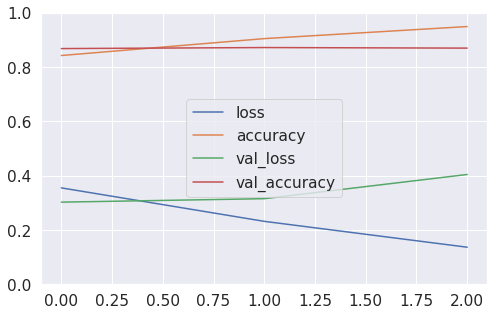

In [658]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

there is a little bit of overfitting here, could be tweaked a bit more to aviid that

In [659]:
model.evaluate(test_dataset)

1250/1250 [==============================] - 52s 40ms/step - loss: 0.4154 - accuracy: 0.8654


[0.4154477119445801, 0.8654000163078308]

# Evaluation

In [660]:
from sklearn import metrics

def evaluate(model, test_dataset, test_labels):
  pred_output = model.predict(test_dataset)
  y_pred_prob = tf.nn.softmax(pred_output.logits,axis=-1).numpy()
  threshold = 0.5
  y_true = test_labels
  y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)
  return {
            'accuracy_score': metrics.accuracy_score(y_true, y_pred_bool),
            'precision_score': metrics.precision_score(y_true, y_pred_bool),
            'recall_score': metrics.recall_score(y_true, y_pred_bool),
        }

In [661]:
evaluate(model, test_dataset, test_labels)

{'accuracy_score': 0.8654,
 'precision_score': 0.8857894736842106,
 'recall_score': 0.8396527639193774}

In [662]:
pred_output = model.predict(test_dataset)
y_pred_prob = tf.nn.softmax(pred_output.logits,axis=-1).numpy()
threshold = 0.5
y_true = test_labels
y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)

### evaluation visualisation

In [663]:
import pathlib
import pandas as pd
import numpy as np
import datetime
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import scikitplot as skplt


class EvaluationReport:
    def __init__(self, y_true, y_pred_prob, threshold: float):
        """
        Provides evaluation metrics & plotting for churn prediction purposes.
        Args:
            y_true: array-like, array of true labels
            y_pred_prob: array-like, predicted probability, with one column per class - just like output of scikit_model.predict_proba,
                0th column should be churn == False probability, 1th column churn == True probability
            threshold: threshold for binary classification label
        """
        self.y_true = y_true
        self.y_pred_prob = y_pred_prob
        self.y_pred_bool = (y_pred_prob[:, 1] >= threshold).astype(bool)
        self.threshold = threshold
        self.predictions_explanations = pd.DataFrame()
    def plot_confusion_matrix(self):
        """
        Plots pretty confusion matrix.
        """
        assert self.y_true.values.dtype == 'bool' and self.y_pred_bool.dtype == 'bool'
        cm = confusion_matrix(self.y_true.values, self.y_pred_bool)
        tn, fp, fn, tp = cm.ravel()
        matrix_to_plot = [[tp, fp], [fn, tn]]

        group_names = ['TN', 'FP', 'FN', 'TP']
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentages = [
            '{0:.2%} of all'.format(value) for value in cm.flatten() / np.sum(cm)
        ]
        row_percentages = [
            '{0:.2%} of negatives'.format(tn / (tn + fn)),
            '{0:.2%} of positives'.format(fp / (tp + fp)),
            '{0:.2%} of negatives'.format(fn / (fn + tn)),
            '{0:.2%} of positives'.format(tp / (tp + fp)),
        ]
        labels = [
            f'{v1}\n{v2}\n{v3}\n{v4}'
            for v1, v2, v3, v4 in zip(
                group_names, group_counts, group_percentages, row_percentages
            )
        ]
        tn, fp, fn, tp = labels
        labels = [[tp, fp], [fn, tn]]
        labels = np.asarray(labels).reshape(2, 2)

        ax = plt.subplot()
        sns.heatmap(
            matrix_to_plot,
            annot=labels,
            cmap="YlGnBu",
            linewidths=0.5,
            fmt='',
            ax=ax,
            cbar=False,
            xticklabels=[True, False],
            yticklabels=[True, False],
            annot_kws={"size": 16},
            square=True,
        )

        sns.set(font_scale=1.4)
        ax.set_xlabel('True values')
        ax.set_ylabel('Predicted values')
        plt.rc("figure", figsize=(10, 10))

    def plot_roc_curve(self):
        """
        Plots ROC curve.
        """
        plt.rc("figure", figsize=(7, 7))
        skplt.metrics.plot_roc(
            self.y_true,
            self.y_pred_prob,
            plot_micro=False,
            plot_macro=False,
            classes_to_plot=True,
            cmap="plasma",
        )
        plt.show()

### confusition matrix ans RoC

In [664]:

r = EvaluationReport(pd.DataFrame(y_true.astype(bool)), y_pred_prob, 0.5)

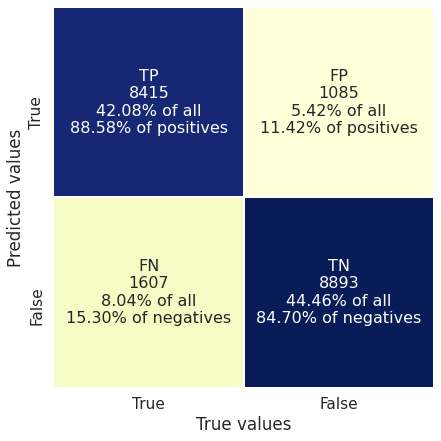

In [665]:
r.plot_confusion_matrix()

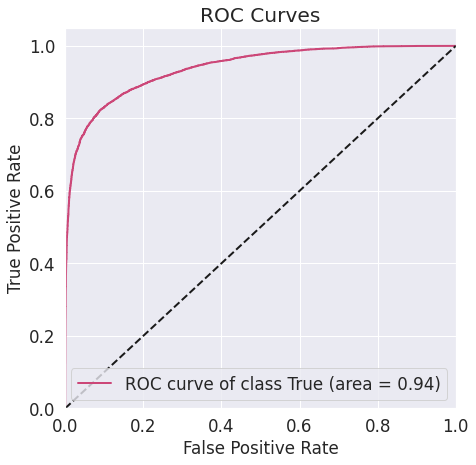

In [666]:
r.plot_roc_curve()

# example prediction & storing artifacts

In [698]:
df.sample(10)

,text,text_clean,is_troll
648644,RT @RelaKStheSlaker: #ItsMuchBetterTo keep you...,ItsMuchBetterTo keep your chapstick with you.,1.0
502219,"RT @redflagnews: Obama Unleashes 3,853 Regs, 1...","Obama Unleashes 3,853 Regs, 18 For Every Law, ...",1.0
529397,RT @Chris_1791: 'Rubio Vice' shows just how Mi...,1791: 'Rubio Vice' shows just how Miami playe...,1.0
50850,@giselle97 @Ryan_H_S @Nifty_Junior @Imogenlemo...,I love JC. Great human our next PM. 😊🙏🏼,0.0
486518,WATCH🚨 Terrorist experts: Obama is the founder...,WATCH🚨 Terrorist experts: Obama is the founder...,1.0
645855,"RT @NolanHack: He mixing if a Hillary wins, to...","He mixing if a Hillary wins, too? TheyreBothTh...",1.0
480683,RT @YoungDems4Trump: This is all Soros' fault ...,This is all Soros' fault via Hillary.,1.0
36234,I don't want to your friend 🎈 @JncFTW https://...,I don't want to your friend 🎈,0.0
73976,RT @Dxpeyy: #CONCOURS 🔥\n\nTENTE DE GAGNER UN ...,CONCOURS 🔥 TENTE DE GAGNER UN FIFA18 LEGACY ES...,0.0
596216,RT @nytimes: Steve Bannon’s role is diminished...,Steve Bannon’s role is diminished as other adv...,1.0


In [667]:
from transformers import pipeline

russian_trolls_pipeline = pipeline('text-classification', model=model, tokenizer=tokenizer, return_all_scores=True) #tockeniser parms?

In [668]:
sample_text = 'BREAKING 🚨 HUGE in streets of ! like real chaos !'
russian_trolls_pipeline(sample_text,truncation=True)

[[{'label': 'LABEL_0', 'score': 0.5548282265663147},
  {'label': 'LABEL_1', 'score': 0.4451717138290405}]]

In [669]:
sample_text = 'I hate hilary and trump'
russian_trolls_pipeline(sample_text, truncation=True)

[[{'label': 'LABEL_0', 'score': 0.010544609278440475},
  {'label': 'LABEL_1', 'score': 0.9894554018974304}]]

In [670]:
sample_text = 'I love pizza, need to talk with God!'
russian_trolls_pipeline(sample_text, truncation=True)

[[{'label': 'LABEL_0', 'score': 0.8969211578369141},
  {'label': 'LABEL_1', 'score': 0.10307884216308594}]]

In [671]:
## artifacts

In [672]:
import datetime
import os

artifact_name = f"trolls_classifier_{datetime.datetime.today().strftime('%Y%m%dT%H%M%S')}"  
artifact_dir = "artifacts/" + artifact_name
os.makedirs(artifact_dir)

In [673]:
artifact_dir

'artifacts/trolls_classifier_20210611T220639'

In [674]:
tokenizer.save_pretrained(artifact_dir)
model.save_pretrained(artifact_dir)

In [675]:
!tar -zcvf {artifact_dir}.tar.gz {artifact_dir}

artifacts/trolls_classifier_20210611T220639/
artifacts/trolls_classifier_20210611T220639/config.json
artifacts/trolls_classifier_20210611T220639/tf_model.h5
artifacts/trolls_classifier_20210611T220639/tokenizer_config.json
artifacts/trolls_classifier_20210611T220639/special_tokens_map.json
artifacts/trolls_classifier_20210611T220639/vocab.txt
artifacts/trolls_classifier_20210611T220639/tokenizer.json


In [676]:
from transformers import TFAutoModelWithLMHead, AutoTokenizer

tokenizer_loaded = AutoTokenizer.from_pretrained(artifact_dir)
model_loaded = TFDistilBertForSequenceClassification.from_pretrained(artifact_dir)

Some layers from the model checkpoint at artifacts/trolls_classifier_20210611T220639 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_514']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at artifacts/trolls_classifier_20210611T220639 and are newly initialized: ['dropout_534']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [677]:
russian_trolls_pipeline_loaded = pipeline('text-classification', model=model_loaded, tokenizer=tokenizer_loaded, return_all_scores=True) 

In [691]:
sample_text = 'BREAKING 🚨 HUGE in streets of ! like real chaos !'
output = russian_trolls_pipeline_loaded(sample_text,truncation=True)

In [697]:
for i in output[0]:
    if i["label"] == "LABEL_1":
      probability = i["score"]
      prediction = i["score"] > threshold

{'label': 'LABEL_1', 'score': 0.4451717138290405}


# shapley values

In [679]:
#the above can be deployed

In [714]:
short_data = df.sample(1).text_clean.values

In [715]:
# define the explainer
explainer = shap.Explainer(russian_trolls_pipeline,  russian_trolls_pipeline.tokenizer)

In [706]:
short_data

array(['Incredibly satisfying to watch'], dtype=object)

In [721]:
shap_values = explainer(["WATCH🚨 Terrorist experts: Obama is the founder of ISIS"])


In [722]:
type(shap_values)

shap._explanation.Explanation

In [723]:
shap.plots.text(shap_values[:,:,"LABEL_1"])
